### Feature type: 'assessment_overall'; Regression on: 'group'
            REUSE == F   REUSE == T
'train'       0.453        0.501        
'test'        0.419        0.428    
'combined'    0.452        0.496    


### Feature type: 'assessment' + 'assessment_overall'; Regression on: 'group'
            REUSE == F   REUSE == T
'train'       0.491        0.525        
'test'        0.378        0.444    
'combined'    0.483        0.519    


In [1]:
import os
from sys import getsizeof
import time
import re
from importlib import reload
import joblib 
import gc
import random
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer 
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.metrics import make_scorer 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import plot_importance
from xgboost.sklearn import XGBRegressor 

pd.options.mode.chained_assignment = None  # default='warn'. Disable SettingWithCopyWarning.
Kaggle = False  # whether this notebook is ran on Kaggle kernel. If true, skip loading raw to same run time and memory.

if Kaggle:
    # change directory to the dataset where custom scripts are found
    os.chdir("/kaggle/input/2019dsb-temp/") 
    # read in custom modules 
    from data_util import *
    from model_util import *
    # reset our working directory
    os.chdir("/kaggle/working/")
else:
    from data_util import *
    from model_util import *
    # for auto reload a module after editing.
    %load_ext autoreload
    %autoreload 2

# Load Data

In [2]:
# Input data path
ROOT = '..' if Kaggle else '.'
DATA_DIR  = os.path.join(ROOT, 'input')
if Kaggle:
    DATA_DIR  = os.path.join(ROOT, 'input', 'data-science-bowl-2019')
    MY_DATA_DIR = os.path.join(ROOT, 'input', '2019dsb-temp')
    TRAIN_XY_PATH = os.path.join(MY_DATA_DIR, 'train_Xy.csv')
TRAIN_PATH = os.path.join(DATA_DIR, 'train.csv')
TEST_PATH = os.path.join(DATA_DIR, 'test.csv')
TRAIN_LABEL_PATH = os.path.join(DATA_DIR, 'train_labels.csv')
SUB_SAMPLE_PATH = os.path.join(DATA_DIR, 'sample_submission.csv')

# Read input data
print("\n/########## Load Data ##########/\n")
t0 = time.time()
if Kaggle:
    train_Xy_df = pd.read_csv(TRAIN_XY_PATH)
else:
    train_df = pd.read_csv(TRAIN_PATH)
    print('train_df shape:', train_df.shape, ', load time: {0:.1f} seconds.'.format((time.time() - t0)))
    
t1 = time.time()
test_df  = pd.read_csv(TEST_PATH)
train_label_df0 = pd.read_csv(TRAIN_LABEL_PATH)
print('test_df shape:', test_df.shape, ', load time: {0:.1f} seconds.'.format((time.time() - t1)))


/########## Load Data ##########/

train_df shape: (11341042, 11) , load time: 67.5 seconds.
test_df shape: (1156414, 11) , load time: 4.8 seconds.


# Process Data

- **train_df, test_df**: raw data
- **train_label_df, test_label_df**: dataframes recording information of assessment sessions (labels).
- **train_proc_df, test_proc_df**: dataframes recording information of all game sessions (features and labels).
- **train_Xy_df, test_Xy_df**: build from train_proc_df and test_proc_df, that can directly fit in the model.

In [21]:
# Setup directory
PROC_DIR = os.path.join('.', 'processed')
if not os.path.exists(PROC_DIR):
    os.makedirs(PROC_DIR)
    
TRAIN_LABEL_PATH_ = os.path.join(PROC_DIR, 'train_labels_sortByTime.csv')
TEST_LABEL_PATH_  = os.path.join(PROC_DIR, 'test_labels_sortByTime.csv')
TRAIN_PROC_PATH = os.path.join(PROC_DIR, 'train_proc.csv')
TEST_PROC_PATH  = os.path.join(PROC_DIR, 'test_proc.csv')
TRAIN_XY_PATH = os.path.join(PROC_DIR, 'train_Xy.csv')
TEST_XY_PATH  = os.path.join(PROC_DIR, 'test_Xy.csv')
FEATURE_SPECS_PATH = os.path.join(PROC_DIR, 'feature_specs.csv')

if not Kaggle:
    TRAIN_USERS = train_df['installation_id'].unique() if not Kaggle else train_Xy_df['installation_id'].unique()
TRAIN_USERS_wLabel = train_label_df0['installation_id'].unique()
TEST_USERS  = test_df['installation_id'].unique()

# Get proc_df
print("\n/########## Extract proc_df ##########/\n")
# PROC_DF_COLUMNS = ['game_session', 'installation_id', 'title', 'start_time', 'start_time_parsed', 'type', 'f0', ..., 'f11']
if not Kaggle:
    get_process_csv(train_df[train_df['type'] == 'Assessment'], TRAIN_USERS_wLabel, TRAIN_PROC_PATH, is_test=False)
    train_proc_df = pd.read_csv(TRAIN_PROC_PATH)
    print('train_proc_df shape:', train_proc_df.shape)
    
get_process_csv(test_df[test_df['type'] == 'Assessment'], TEST_USERS, TEST_PROC_PATH, is_test=True)
test_proc_df = pd.read_csv(TEST_PROC_PATH)
print('test_proc_df shape: ', test_proc_df.shape)
test_label_df  = test_proc_df[test_proc_df['type'] == 'Assessment'].iloc[:, :8]
TEST_USERS_wMultiAssess = test_label_df.dropna()['installation_id'].unique()    # can be used as part of train.


# Get Xy_df
print("\n/########## Build Xy_df ##########/\n")
if not Kaggle:
    get_Xy_csv(train_proc_df, TRAIN_XY_PATH, FEATURE_SPECS_PATH)
    train_Xy_df = pd.read_csv(TRAIN_XY_PATH)
get_Xy_csv(test_proc_df, TEST_XY_PATH, FEATURE_SPECS_PATH)
test_Xy_df  = pd.read_csv(TEST_XY_PATH)
feature_specs_df = pd.read_csv(FEATURE_SPECS_PATH, keep_default_na=False)
print('train_Xy_df shape:', train_Xy_df.shape)
print('test_Xy_df shape: ', test_Xy_df.shape)

print('\n')
if not Kaggle:
    print('TRAIN_USERS num: ', len(TRAIN_USERS))
print('TRAIN_USERS_wLabel num: ', len(TRAIN_USERS_wLabel))
print('TEST_USERS num: ', len(TEST_USERS))
print('TEST_USERS_wMultiAssess num: ', len(TEST_USERS_wMultiAssess))

ASSESSMENTS = np.sort(train_Xy_df['assessment_title'].unique())

if Kaggle:
    del test_df
    gc.collect()
    time.sleep(3)


/########## Extract proc_df ##########/

Finished extracting features. Time: 48.1 seconds.
train_proc_df shape: (17690, 19)
Finished extracting features. Time: 8.6 seconds.
test_proc_df shape:  (3018, 19)

/########## Build Xy_df ##########/



/Users/zhao/Dropbox/Jupyter_notebooks/Kaggle_2019_Data_Science_Bowl/data_util.py:606: RuntimeWarning: invalid value encountered in long_scalars
  Xy_df[col7].iloc[i:row_end] = sum_perc_growth / count_perc_growth  # mean perc_growth
/Users/zhao/Dropbox/Jupyter_notebooks/Kaggle_2019_Data_Science_Bowl/data_util.py:606: RuntimeWarning: invalid value encountered in double_scalars
  Xy_df[col7].iloc[i:row_end] = sum_perc_growth / count_perc_growth  # mean perc_growth


Finish creating Xy_df. Time: 45.1 seconds.
Finish creating Xy_df. Time: 6.2 seconds.
train_Xy_df shape: (17690, 139)
test_Xy_df shape:  (3018, 139)


TRAIN_USERS num:  17000
TRAIN_USERS_wLabel num:  3614
TEST_USERS num:  1000
TEST_USERS_wMultiAssess num:  557


# Training with Cross-Validation

- **dummy_train_Xy_df, dummy_test_Xy_df**: 'dummy_train' and 'dummy_test' prefix means the samples actually used for train and test.
- Note the difference in the distribution of train set and test set, as shown by the histogram below. **In the test set, there're more data points that haven't taken any previous assessments.**

dummy_train unique uid: 3614
dummy_train samples: 17690


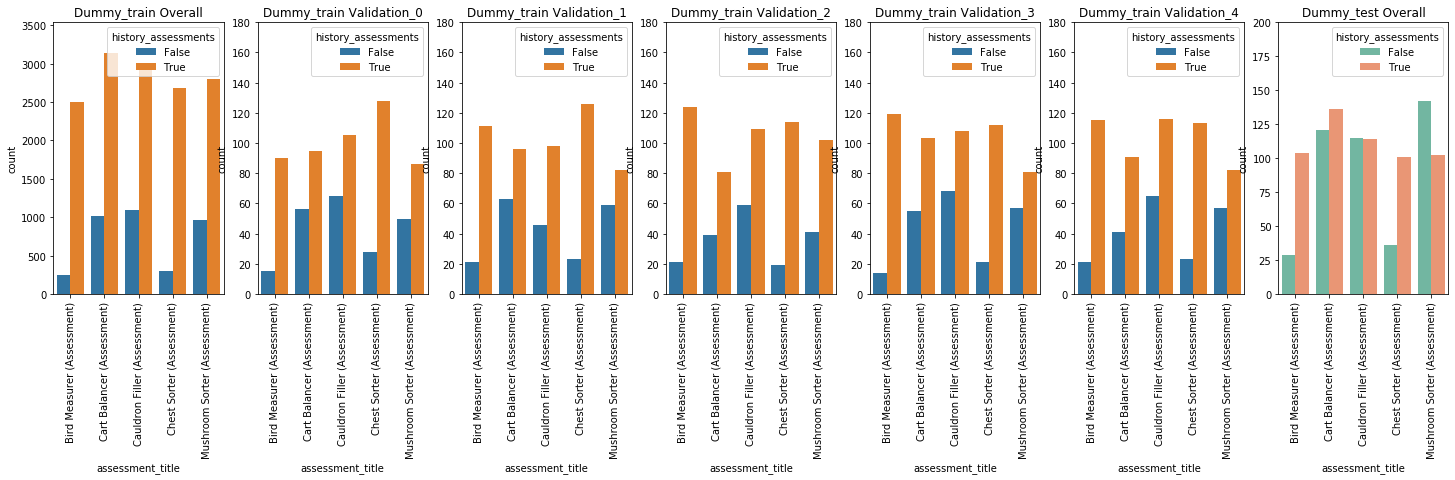

In [64]:
REGRESSION_ON = 'accuracy_group'  # either 'accuracy' or 'accuracy_group'
FINAL_MODEL = 'oof'  # either 'oof' or 'retrain'. 'oof' means use the oof models from cv; 
                     # 'retrain' means re-train the model with the whole training set. 
TRAIN_SET = 'train'  # 'train', 'test', or 'combined'
DATA_REUSE = True  
# if DATA_REUSE is True, use all the rows in Xy_df 
#    (one user can contribute to multiple train points if he did multiple assessments ); 
# else, only take the rows where 'is_last_assessment' == 1
#    (one user only contributes to one train point). 

dummy_train_user = np.concatenate((TRAIN_USERS_wLabel, TEST_USERS_wMultiAssess))
test_wlabel_df = test_Xy_df[test_Xy_df['is_last_assessment'] == 0]
test_temp_df = test_wlabel_df.groupby('installation_id').tail(1)
test_wlabel_df.loc[test_temp_df.index, 'is_last_assessment'] = 1
dummy_train_Xy_df = pd.concat([train_Xy_df, test_wlabel_df], ignore_index=True)
dummy_train_Xy_df['from_test'] = dummy_train_Xy_df['installation_id'].isin(TEST_USERS_wMultiAssess)
dummy_test_Xy_df  = test_Xy_df[test_Xy_df['is_last_assessment'] == 1]

if TRAIN_SET == 'train':
    dummy_train_Xy_df = dummy_train_Xy_df[dummy_train_Xy_df['from_test'] == False] 
elif TRAIN_SET == 'test':
    dummy_train_Xy_df = dummy_train_Xy_df[dummy_train_Xy_df['from_test'] == True] 

if not DATA_REUSE:
    dummy_train_Xy_df = dummy_train_Xy_df[dummy_train_Xy_df['is_last_assessment'] == 1]

dummy_train_Xy_df.reset_index(inplace=True, drop=True)  
dummy_test_Xy_df.reset_index(inplace=True, drop=True)
dummy_train_Xy_df['history_assessments'] = (dummy_train_Xy_df['Assessment Overall_00'] > 0)
dummy_test_Xy_df['history_assessments'] = (dummy_test_Xy_df['Assessment Overall_00'] > 0)
dummy_train_Xy_df['history_same_assessments'] = (dummy_train_Xy_df['others_00'] < 100000)
dummy_test_Xy_df['history_same_assessments'] = (dummy_test_Xy_df['others_00'] < 100000)

print('dummy_train unique uid:', dummy_train_Xy_df['installation_id'].nunique())
print('dummy_train samples:', dummy_train_Xy_df.shape[0])

# cv splitting:
n_splits = 5
cv_splitter = CVSplitter(n_splits, uid_list=dummy_train_user, Xy_df=dummy_train_Xy_df)
dummy_train_Xy_df = cv_splitter.get_split()

# Plot the histogram of assessment types for dummy_train and dummy_test.

plot_feature = 'history_assessments'
fig, ax = plt.subplots(1, 2 + n_splits, figsize=(5 * n_splits, 5))
for i in range(n_splits):
    sns.countplot(x="assessment_title", hue=plot_feature, 
                  data=dummy_train_Xy_df[dummy_train_Xy_df['split_label'] == i], 
                  order=ASSESSMENTS, ax=ax[i+1])
    ax[i+1].set_xticklabels(labels=ASSESSMENTS, rotation=90)
    ax[i+1].set_ylim(top=180)
    ax[i+1].set_title('Dummy_train Validation_{}'.format(i))
sns.countplot(x="assessment_title", hue=plot_feature, data=dummy_train_Xy_df, 
                  order=ASSESSMENTS, ax=ax[0])
ax[0].set_xticklabels(labels=ASSESSMENTS, rotation=90)
ax[0].set_ylim(top=dummy_train_Xy_df.shape[0]/5)
ax[0].set_title('Dummy_train Overall')

sns.countplot(x="assessment_title", hue=plot_feature, data=dummy_test_Xy_df, 
                  order=ASSESSMENTS, palette='Set2', ax=ax[-1])
ax[-1].set_xticklabels(labels=ASSESSMENTS, rotation=90)
ax[-1].set_ylim(top=dummy_test_Xy_df.shape[0]/5)
_ = ax[-1].set_title('Dummy_test Overall')


********************
Bird Measurer (Assessment)
CV mean score on validation_0: 0.891 +/- 0.004 std.
CV mean score on validation_1: 1.029 +/- 0.075 std.
CV mse_error on validation:        1.058, data number: 651.
CV mse_error on validation part 0: 1.215, data number: 92.
CV mse_error on validation part 1: 1.032, data number: 559.
feature number: 30.

********************
Cart Balancer (Assessment)
CV mean score on validation_0: 0.940 +/- 0.003 std.
CV mean score on validation_1: 1.143 +/- 0.045 std.
CV mse_error on validation:        1.305, data number: 720.
CV mse_error on validation part 0: 1.815, data number: 254.
CV mse_error on validation part 1: 1.027, data number: 466.
feature number: 30.

********************
Cauldron Filler (Assessment)
CV mean score on validation_0: 0.887 +/- 0.002 std.
CV mean score on validation_1: 1.017 +/- 0.054 std.
CV mse_error on validation:        1.037, data number: 839.
CV mse_error on validation part 0: 1.344, data number: 303.
CV mse_error on vali

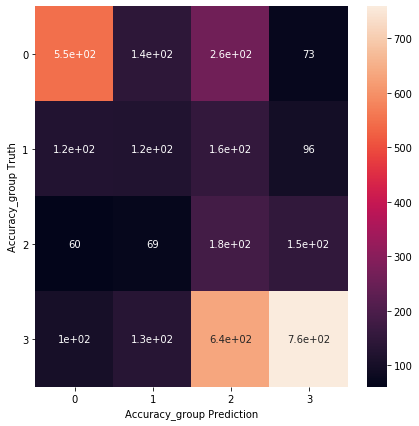

In [68]:
# Setup directories for storing results.
MODEL_NAME = 'baseline_0'
MODEL_DIR  = os.path.join('./models', MODEL_NAME)
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

# Start CV
params = { 
    'n_estimators': 300,  #################
    'max_depth':  5,  #################
    'learning_rate': 0.01, 
#     'min_child_weight': np.arange(1, 4, 1),
#     'gamma': np.arange(0, 0.03, 0.01),
#     'reg_alpha': np.arange(0, 0.01, 0.003),
    'objective': 'reg:squarederror', #['reg:squaredlogerror']#, # squared loss.
    'verbose': False,
    'early_stopping_rounds': None,
    'n_jobs': cpu_count()//2,
    'random_state': 123
}

feature_type_to_drop = feature_specs_df[feature_specs_df['is_sum'] == 1]['feature_type'].to_list() \
                        + ['', 'assessment_overall__perc_grow_count']
feature_type_to_drop.extend(['assessment__dur_last', 'assessment__dur_mean'])
# feature_type_to_drop.extend(['assessment_overall__perc_grow_mean'])
# feature_type_to_drop.extend(['time_from_last_trial'])  #################
            
feature_to_drop = feature_specs_df[feature_specs_df['feature_type'].isin(feature_type_to_drop)]['feature_name'].to_list()
cols_to_drop = ['installation_id', 'is_last_assessment', 'is_first_assessment', 'assessment_title', 
            'accuracy', 'accuracy_group', 'split_label', 'history_assessments', 'history_same_assessments', 'from_test']  \
            + feature_to_drop

y_truth = np.array([])
y_pred  = np.array([])
group_truth = np.array([])

t0 = time.time()
for assessment in ASSESSMENTS[:]:
    print('\n' + '*' * 20)
    print(assessment)
    Xy_assessment = dummy_train_Xy_df[dummy_train_Xy_df['assessment_title'] == assessment]
#     if assessment == ASSESSMENTS[0] or assessment == ASSESSMENTS[3]:
#     Xy_assessment = Xy_assessment[Xy_assessment['from_test'] == False]
    X = Xy_assessment
    y = Xy_assessment.loc[:, REGRESSION_ON]
    assert(np.nan not in y)

    model = RegressorModel(model_wrapper=XGBWrapper_regr())
    model.fit(X, y, params=params, eval_metric='rmse', cols_to_drop=cols_to_drop, plot=False, plot_title=assessment, verbose=1)

    group_oof = X[X['split_label'] >= 0]['accuracy_group']
    y_oof = y[X['split_label'] >= 0]   # split -1 will only be used in train.
    y_oof_pred = pd.Series(model.oof.reshape(-1)).dropna()
    y_oof_pred = y_oof_pred.rename(index=dict(zip(y_oof_pred.index, y_oof.index)))
    mse = mean_squared_error(y_oof, y_oof_pred)

    y_oof_0 = y_oof[X['history_assessments'] == 0] # data that has no previous assessments.
    y_oof_0_pred = y_oof_pred[X['history_assessments'] == 0]
    mse_0 = mean_squared_error(y_oof_0, y_oof_0_pred)
    y_oof_1 = y_oof[X['history_assessments'] == 1] # data that has previous assessments.
    y_oof_1_pred = y_oof_pred[X['history_assessments'] == 1]
    mse_1 = mean_squared_error(y_oof_1, y_oof_1_pred)
    print(f"CV mse_error on validation:        {mse:.3f}, data number: {len(y_oof)}.")
    print(f"CV mse_error on validation part 0: {mse_0:.3f}, data number: {len(y_oof_0)}.")
    print(f"CV mse_error on validation part 1: {mse_1:.3f}, data number: {len(y_oof_1)}.")
    print(f"feature number: {len(model.columns)}.")

    y_truth = np.concatenate((y_truth, y_oof))
    y_pred  = np.concatenate((y_pred, y_oof_pred))
    group_truth = np.concatenate((group_truth, group_oof))
    
    model_path = os.path.join(MODEL_DIR, f"model_{assessment}.pkl")
    model.save_model(model_path)

print('\n' + '*' * 20)
optR = OptimizedRounder(regression_output=REGRESSION_ON, brute_search=True, brute_search_steps=15)
optR.fit(y_pred, group_truth)
print(">>>>>>> Optimized thresholds:", str(['{:.2f}'.format(j) for j in optR.get_coefficients()]).replace("'", ""))
group_pred  = optR.predict(y_pred)
qwk_score = cohen_kappa_score(group_truth, group_pred, weights='quadratic')
print(">>>>>>> Optimized thresholds QWK_score:", qwk_score)
plot_acc_group_cm(group_truth, group_pred)

t1 = time.time()
print(f"time: {t1 - t0:.0f} s")

# Testing and Submission

In [8]:
sample_df = pd.read_csv(SUB_SAMPLE_PATH)
y_test_pred = np.array([])
y_test_uid = np.array([])
y_test_assessment = np.array([])

for assessment in ASSESSMENTS[:]:
    Xy_assessment = dummy_test_Xy_df[dummy_test_Xy_df['assessment_title'] == assessment]
    X = Xy_assessment
    y = Xy_assessment.loc[:, REGRESSION_ON]
    model_path = os.path.join(MODEL_DIR, f"model_{assessment}.pkl")
    model = joblib.load(model_path)
    y_pred = model.predict(X)
    y_test_pred = np.concatenate((y_test_pred, y_pred.reshape(-1)))
    y_test_uid = np.concatenate((y_test_uid, Xy_assessment['installation_id']))

y_test_group_pred  = optR.predict(y_test_pred)
submission_df = pd.DataFrame({
    'installation_id': y_test_uid,
    'accuracy_group': y_test_group_pred
})
assert(sample_df.shape == submission_df.shape)
submission_df = submission_df.sort_values(by='installation_id')
submission_df.to_csv('./submission.csv', index=False)

In [ ]:
"""
Correlation analysis
"""

# train_Xy_df_last = train_Xy_df[train_Xy_df['is_last_assessment'] == 1]
# print('train_Xy_df_last:', train_Xy_df_last.shape)
# for assessment in ASSESSMENTS[:]:
#     assessment_Xy = train_Xy_df_last[train_Xy_df_last['assessment_title'] == assessment]
#     print(assessment, assessment_Xy.shape)
#     fig, ax = plt.subplots(1, 5, figsize=(24, 4))
#     fig.tight_layout()
#     for j in range(5):
#         fi = 5
#         param_assessment = ASSESSMENTS[j]
#         param_col = param_assessment + '_f0' + str(fi)
#         temp_Xy0 = assessment_Xy[assessment_Xy[str(param_assessment + '_00')] > 1]
#         temp_Xy = temp_Xy0[['accuracy', 'accuracy_group', param_col]].dropna()
        
# #         ax[j].hist2d(temp_Xy[param_col], temp_Xy['accuracy_group'], cmap=plt.cm.jet)
# # #         sns.regplot(temp_Xy[param_col], temp_Xy['accuracy_group'], ax=ax[j])
# #         r2 = r2_score(temp_Xy[param_col], temp_Xy['accuracy_group'])
# #         ax[j].set_title(param_assessment + ', data: {}, r2: {:.2f}'.format(temp_Xy.shape[0], r2))
        
#         cm = confusion_matrix(temp_Xy[param_col], temp_Xy['accuracy_group'], np.arange(4))
#         qwk_score = cohen_kappa_score(temp_Xy[param_col], temp_Xy['accuracy_group'], weights='quadratic')
#         sns.heatmap(cm, annot=True, ax=ax[j])
#         ax[j].set_title(param_assessment + ', data: {}, qwk: {:.2f}'.format(temp_Xy.shape[0], qwk_score))

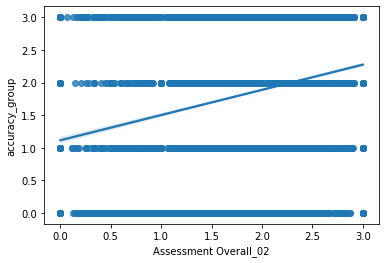

In [80]:
xxx = dummy_train_Xy_df['Assessment Overall_02']
yyy = dummy_train_Xy_df['accuracy_group']
sns.regplot(xxx, yyy)